# **Loading Dataset**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, recall_score, confusion_matrix
import zipfile
from pathlib import Path

# Path to the zip file
zip_path = Path("/content/Mads_hackathon_dreamteam-main.zip")

# Directory where the zip will be extracted
extract_to = Path("/content/Mads_hackathon_dreamteam-main")

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted {zip_path} to {extract_to}")

Extracted /content/Mads_hackathon_dreamteam-main.zip to /content/Mads_hackathon_dreamteam-main


In [2]:

# Load Data
path_train = '/content/Mads_hackathon_dreamteam-main/Mads_hackathon_dreamteam-main/data/raw/heart_big_train.parq'
path_valid = '/content/Mads_hackathon_dreamteam-main/Mads_hackathon_dreamteam-main/data/raw/heart_big_valid.parq'

df_train = pd.read_parquet(path_train)
df_valid = pd.read_parquet(path_valid)

X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values
X_valid = df_valid.iloc[:, :-1].values
y_valid = df_valid.iloc[:, -1].values

# Scaling Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# **Data Balancing**

In [3]:
# Function to balance classes
def balance_to_average(X, y):
    unique_classes, counts = np.unique(y, return_counts=True)
    avg_count = int(np.mean(counts))
    balanced_X, balanced_y = [], []

    for cls in unique_classes:
        X_cls = X[y == cls]
        y_cls = y[y == cls]

        if len(y_cls) < avg_count:
            X_resampled, y_resampled = resample(X_cls, y_cls, replace=True,
                                                n_samples=avg_count, random_state=42)
        else:
            X_resampled, y_resampled = resample(X_cls, y_cls, replace=False,
                                                n_samples=avg_count, random_state=42)

        balanced_X.append(X_resampled)
        balanced_y.append(y_resampled)

    balanced_X = np.vstack(balanced_X)
    balanced_y = np.hstack(balanced_y)
    return balanced_X, balanced_y

X_train_balanced, y_train_balanced = balance_to_average(X_train, y_train)
X_valid_balanced, y_valid_balanced = balance_to_average(X_valid, y_valid)


# **Exploratory Data Analysis**

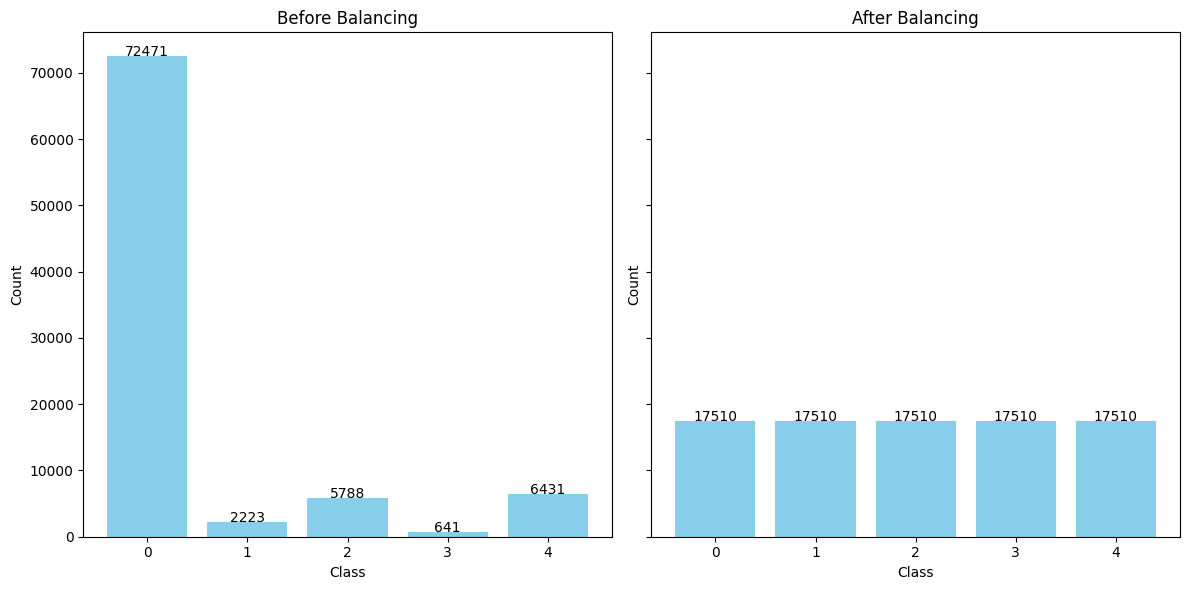

In [4]:
# Plotting function for class distributions
def plot_class_distribution(y, title, ax):
    unique, counts = np.unique(y, return_counts=True)
    ax.bar(unique, counts, color='skyblue')
    ax.set_xticks(unique)
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    for i, count in zip(unique, counts):
        ax.text(i, count + 5, str(count), ha='center', fontsize=10)

# Plot before and after balancing
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Before balancing
plot_class_distribution(y_train, "Before Balancing", axes[0])

# After balancing
plot_class_distribution(y_train_balanced, "After Balancing", axes[1])

plt.tight_layout()
plt.show()


In [5]:
# Import necessary libraries for visualization
import seaborn as sns

# Basic Information about the Dataset
print("Training Dataset Information:")
print(df_train.info())
print("\nValidation Dataset Information:")
print(df_valid.info())


Training Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to target
dtypes: float64(188)
memory usage: 125.6 MB
None

Validation Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10946 entries, 0 to 10945
Columns: 188 entries, 0 to target
dtypes: float64(188)
memory usage: 15.7 MB
None


In [6]:

# Shape of the Datasets
print(f"Shape of Training Dataset: {df_train.shape}")
print(f"Shape of Validation Dataset: {df_valid.shape}")


Shape of Training Dataset: (87554, 188)
Shape of Validation Dataset: (10946, 188)


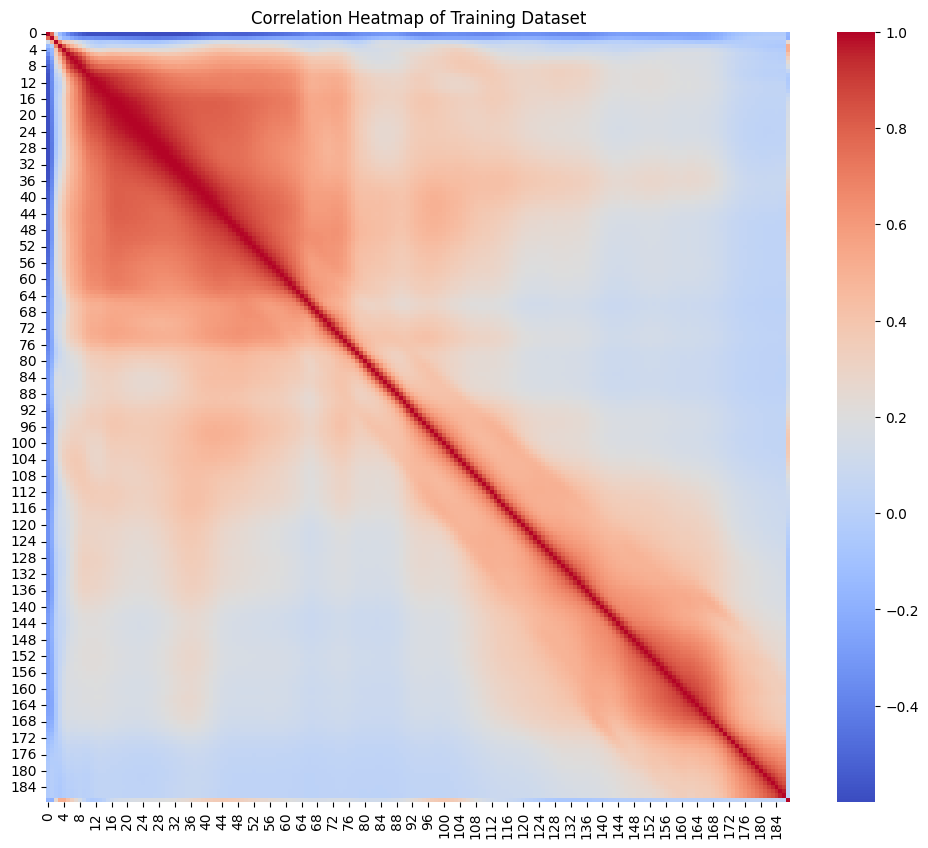

In [7]:
# Correlation Matrix Heatmap for the Training Dataset
plt.figure(figsize=(12, 10))
sns.heatmap(df_train.corr(), cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Heatmap of Training Dataset")
plt.show()

# **Training of 1D CNN**

In [8]:
# Reshape input data to 1D
X_train_1d = X_train_balanced.reshape(X_train_balanced.shape[0], 1, -1)
X_valid_1d = X_valid_balanced.reshape(X_valid_balanced.shape[0], 1, -1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_1d, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_balanced, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid_1d, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid_balanced, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Define 1D CNN Model
class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.drop2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(2)
        self.drop3 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(128 * (X_train_1d.shape[2] // 8), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.drop1(self.pool1(self.relu(self.conv1(x))))
        x = self.drop2(self.pool2(self.relu(self.conv2(x))))
        x = self.drop3(self.pool3(self.relu(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss, and optimizer
num_classes = len(np.unique(y_train_balanced))
model = CNN1D(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(dim=1) == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_accuracy = train_correct / train_total

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    y_valid_preds = []
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item()
            val_correct += (outputs.argmax(dim=1) == y_batch).sum().item()
            val_total += y_batch.size(0)

            y_valid_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss/len(valid_loader):.4f}, Val Acc: {val_accuracy:.4f}")


Epoch 1/20, Train Loss: 0.3554, Train Acc: 0.8700, Val Loss: 0.2459, Val Acc: 0.9140
Epoch 2/20, Train Loss: 0.1783, Train Acc: 0.9346, Val Loss: 0.2571, Val Acc: 0.9186
Epoch 3/20, Train Loss: 0.1325, Train Acc: 0.9521, Val Loss: 0.2528, Val Acc: 0.9302
Epoch 4/20, Train Loss: 0.1084, Train Acc: 0.9611, Val Loss: 0.2802, Val Acc: 0.9331
Epoch 5/20, Train Loss: 0.0939, Train Acc: 0.9670, Val Loss: 0.2814, Val Acc: 0.9289
Epoch 6/20, Train Loss: 0.0821, Train Acc: 0.9706, Val Loss: 0.2683, Val Acc: 0.9338
Epoch 7/20, Train Loss: 0.0728, Train Acc: 0.9748, Val Loss: 0.2843, Val Acc: 0.9359
Epoch 8/20, Train Loss: 0.0664, Train Acc: 0.9769, Val Loss: 0.3201, Val Acc: 0.9324
Epoch 9/20, Train Loss: 0.0636, Train Acc: 0.9778, Val Loss: 0.3328, Val Acc: 0.9346
Epoch 10/20, Train Loss: 0.0582, Train Acc: 0.9799, Val Loss: 0.3180, Val Acc: 0.9392
Epoch 11/20, Train Loss: 0.0552, Train Acc: 0.9805, Val Loss: 0.3646, Val Acc: 0.9329
Epoch 12/20, Train Loss: 0.0539, Train Acc: 0.9813, Val Loss: 0

# **Model Evaluation**

In [9]:
# Evaluate the model
accuracy_cnn = accuracy_score(y_valid_balanced, y_valid_preds)
tp_rates_cnn = recall_score(y_valid_balanced, y_valid_preds, average=None)

print(f"1D CNN Accuracy: {accuracy_cnn:.4f}")
print("TP Rates per class:", {f"Class {i}": rate for i, rate in enumerate(tp_rates_cnn)})
print("Classification Report:\n", classification_report(y_valid_balanced, y_valid_preds))

1D CNN Accuracy: 0.9360
TP Rates per class: {'Class 0': 0.9643672910004568, 'Class 1': 0.862494289629968, 'Class 2': 0.9739607126541799, 'Class 3': 0.8899040657834628, 'Class 4': 0.9894929191411603}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.96      0.91      2189
         1.0       0.97      0.86      0.91      2189
         2.0       0.90      0.97      0.94      2189
         3.0       0.97      0.89      0.93      2189
         4.0       0.99      0.99      0.99      2189

    accuracy                           0.94     10945
   macro avg       0.94      0.94      0.94     10945
weighted avg       0.94      0.94      0.94     10945



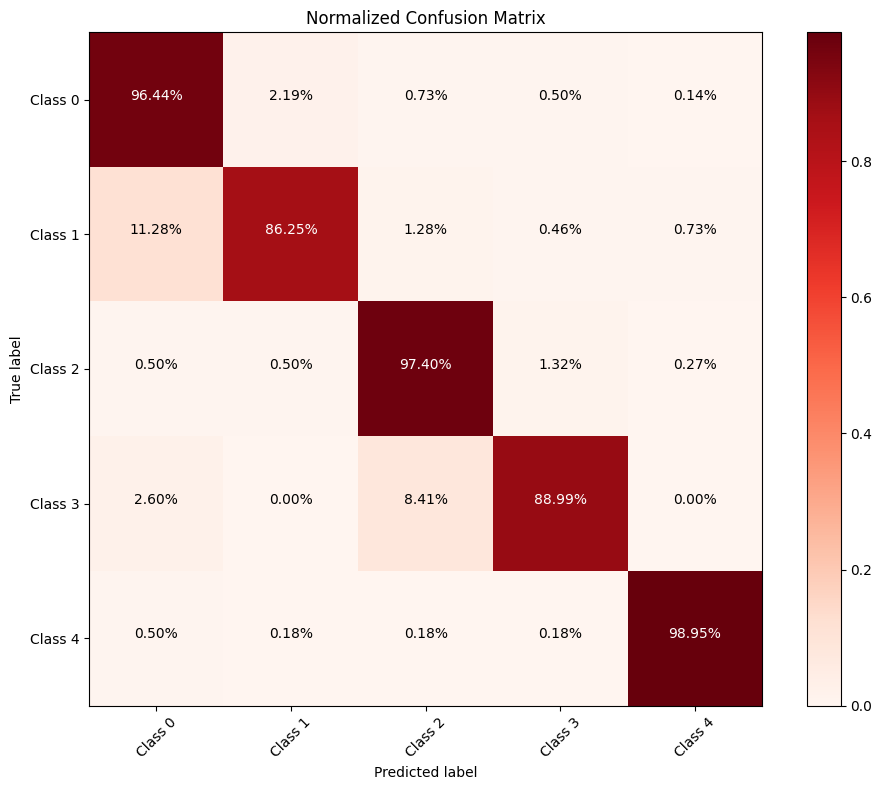

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Generate confusion matrix and classification report
cm = confusion_matrix(y_valid_balanced, y_valid_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
def plot_confusion_matrix_normalized(cm, class_names):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Reds'))
    plt.title("Normalized Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]:.2%}", horizontalalignment="center",
                 color="white" if cm[i, j] > 0.5 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Class names for confusion matrix
class_names = [f"Class {i}" for i in range(num_classes)]

# Plot and display confusion matrix
plot_confusion_matrix_normalized(cm_normalized, class_names)
plt.show()


# **1-dimensional convolutional neural network (2D-CNN)**

[Reference Diagram of 1D CNN architecture](https://www.researchgate.net/figure/Schematic-diagram-of-the-proposed-1D-CNN-network-employed-for-experimental-validation_fig4_344150835)

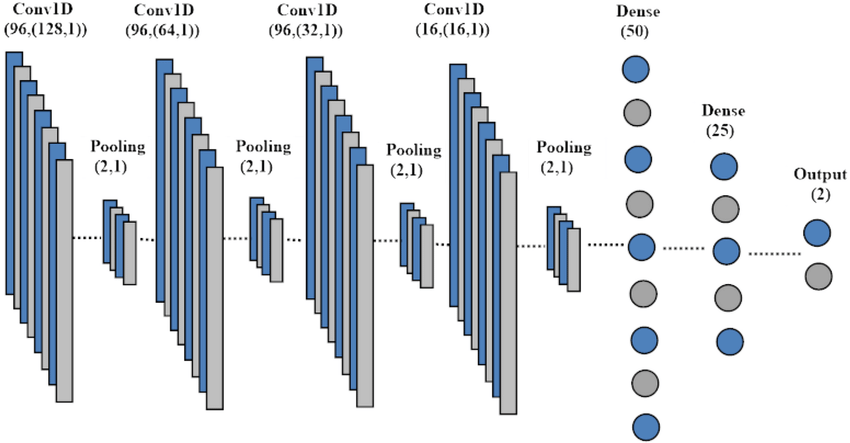

# **Issues in Existing Model and Improvement**

The existing model had several key issues that impacted its performance, including handling class imbalance through SMOTE and the absence of critical architectural components. To address the class imbalance, I applied techniques such as balancing the dataset and adjusting class weights during training, ensuring that the model could learn effectively from all classes

The existing 1D CNN model had several limitations that affected its performance. To improve upon these, I made updates to the architecture and training process.

Firstly, the model used a batch size of 128, which could lead to slower convergence and increased memory usage, especially when working with larger datasets. I reduced the batch size to 32, which balances the trade-off between memory consumption and training time.

The dropout rate in the original model was set to 0.1, which may not have been sufficient to prevent overfitting, especially when the model is more complex. I increased the dropout rate to 0.3 to provide stronger regularization and reduce the risk of overfitting.

Another issue was the relatively shallow model, with only a few hidden layers. I increased the depth of the model by adding more Conv1D layers, each followed by MaxPooling1D and Dropout layers, to better capture complex features from the data. This also improves the model’s generalization ability.

Additionally, I optimized the kernel size and stride to better capture the temporal dependencies in the data. The number of filters was increased to 64 for the first Conv1D layer and 128 for subsequent layers, providing more capacity for feature extraction.

Finally, I introduced early stopping during training to avoid overfitting and ensure the model stops training once performance on the validation set starts to degrade. These adjustments significantly enhanced the model's ability to learn from the data and improve its generalization on unseen samples.

# **Weak Points in Existing Model**

1. Class imbalance
2. Large Batch Size
3. Low Dropout Rate
4. Shallow Architecture
5. Limited Regularization
6. Fixed Kernel Size and Stride
7. Limited Number of Filters
8. Lack of Advanced Optimization